In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import calendar;
import time;
from torch.utils.data import TensorDataset, DataLoader

## Generate Dataset

In [2]:
# Regenerate the same 2D GMM data
def generate_gmm_data(num_data, d, n_components=4, random_state=42, means=None, vars=None, sizes=None, tags=None):
    rng = np.random.default_rng(random_state)
    weights = np.ones(n_components) if sizes is None else np.array(sizes)
    weights /= weights.sum()
    if means is None: 
        means = rng.uniform(-20, 20, size=(n_components, d))
    else: 
        means = np.array(means)
    # covariances = np.array([np.diag(rng.uniform(0.1, 0.2, size=d)) for _ in range(n_components)])
    if vars is None:
        covariances = rng.uniform(0.1, 0.2, size=(n_components, d))
    else:
        covariances = np.array([np.diag([var]*d) for var in vars])
    labels = rng.choice(n_components, size=num_data, p=weights)
    X = np.empty((num_data, d))
    for k in range(n_components):
        mask = (labels == k)
        X[mask] = rng.multivariate_normal(means[k], covariances[k], size=mask.sum())
    return X, labels

In [30]:
def generate_gmm_data(d, n_components=4, random_state=42, num_data=1000, 
                            means=None, vars=None, sizes=None, tags=None):
    """
    Generate a GMM dataset with exact cluster sizes and custom string labels.

    - sizes: list of exact number of samples for each component; sum(sizes) == num_data
    - tags: list of string labels for each component

    Returns:
    - X: (num_data, d)
    - labels: (num_data,) array of strings (from tags)
    """
    rng = np.random.default_rng(random_state)

    if sizes is None:
        sizes = [num_data // n_components] * n_components
        sizes[-1] += num_data - sum(sizes)
    else:
        sizes = list(sizes)
        assert len(sizes) == n_components, "Sizes must match the number of components"
        num_data = sum(sizes)   # adjust num_data to match sizes

    if tags is None:
        tags = [str(i) for i in range(n_components)]
    else:
        assert len(tags) == n_components

    if means is None:
        means = rng.uniform(-20, 20, size=(n_components, d))
    else:
        means = np.array(means, dtype=float)
        assert means.shape == (n_components, d)

    if vars is None:
        covariances = [np.diag(rng.uniform(0.1, 0.2, size=d)) for _ in range(n_components)]
    else:
        covariances = [np.diag([var]*d) for var in vars]

    X = []
    labels = []
    for k in range(n_components):
        Xk = rng.multivariate_normal(means[k], covariances[k], size=sizes[k])
        X.append(Xk)
        labels.extend([tags[k]] * sizes[k])
    X = np.vstack(X)
    labels = np.array(labels)
    perm = rng.permutation(num_data)
    return X[perm], labels[perm]

def zscore_normalize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0, ddof=0)

In [40]:
# training means and shared std
means_train = [
    # np.array([120.0, 320.0, 1650.0, 2250.0]),  # /y/
    # np.array([120.0, 320.0,  800.0, 2250.0]),  # /u/
    np.array([320.0, 1650.0]),  # /y/
    np.array([320.0, 800.0]),  # /u/
]
var_strength = 50.0  # Hz in all dimensions
vars_train = [var_strength, var_strength]
sizes_train = [500, 500]  # for example
tags_train = ["y", "u"]

In [41]:
X, labels = generate_gmm_data(d=2, n_components=len(tags_train), random_state=calendar.timegm(time.gmtime()), means=means_train, vars=vars_train, sizes=sizes_train, tags=tags_train)

In [42]:
label_names, labels_numeric = np.unique(labels, return_inverse=True)

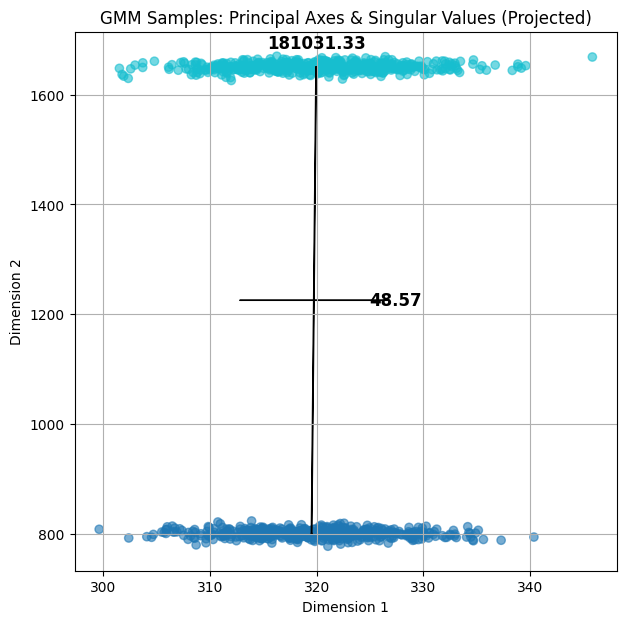

In [43]:
def plot_2d_projection_with_principal_axes(X, labels, dim_x=0, dim_y=1, label_names=None):
    """
    X: (N, d) array (d >= 2)
    labels: length-N int or string labels
    dim_x, dim_y: which dimensions to plot (0-based)
    label_names: list of label strings, or None to skip legend
    """
    # Map string labels to numeric for color
    label_names_unique, labels_numeric = np.unique(labels, return_inverse=True)
    
    # Compute mean and covariance in full space
    mu = X.mean(axis=0)
    C = np.cov(X, rowvar=False)
    U, S, Vt = np.linalg.svd(C)

    # 2D mean for plot
    mu2 = mu[[dim_x, dim_y]]

    plt.figure(figsize=(7, 7))
    # Scatterplot of projection
    plt.scatter(X[:, dim_x], X[:, dim_y], c=labels_numeric, alpha=0.6, cmap='tab10', label='')

    # Draw and label first two principal axes, projected
    for i in range(2):
        vec = U[:, i] * np.sqrt(S[i])
        vec2 = vec[[dim_x, dim_y]]
        plt.arrow(mu2[0], mu2[1], vec2[0], vec2[1], width=0.05, length_includes_head=True, label=f'σ{i+1}')
        plt.arrow(mu2[0], mu2[1], -vec2[0], -vec2[1], width=0.05, length_includes_head=True)
        plt.text(mu2[0] + vec2[0]*1.1, mu2[1] + vec2[1]*1.1, f'{S[i]:.2f}', fontsize=12, fontweight='bold', ha='center', va='center')

    plt.xlabel(f"Dimension {dim_x+1}")
    plt.ylabel(f"Dimension {dim_y+1}")
    plt.title("GMM Samples: Principal Axes & Singular Values (Projected)")
    plt.grid(True)

    # Legend with class names, if available
    if label_names is not None:
        for i, name in enumerate(label_names_unique):
            plt.scatter([], [], c=[plt.cm.tab10(i)], label=name)
        plt.legend(title="Class")

    plt.show()

# Example usage
plot_2d_projection_with_principal_axes(X, labels, dim_x=0, dim_y=1)


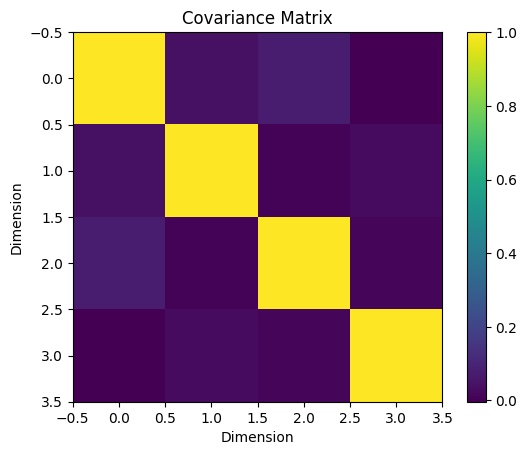

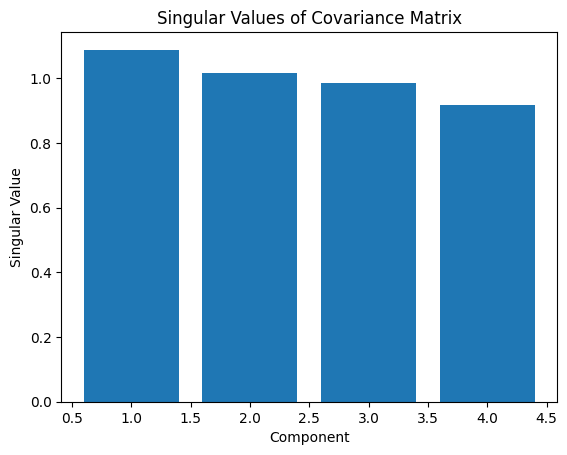

In [37]:
# 1) Covariance matrix heatmap
C = np.cov(X_normed, rowvar=False)
plt.figure()
plt.imshow(C, aspect='equal')
plt.colorbar()
plt.title("Covariance Matrix")
plt.xlabel("Dimension")
plt.ylabel("Dimension")
plt.show()

# 2) Singular values
U, S, Vt = np.linalg.svd(C)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S)
plt.xlabel("Component")
plt.ylabel("Singular Value")
plt.title("Singular Values of Covariance Matrix")
plt.show()